# MOACIR - Mais Outro Algoritmo Classificador de Imagens da Roça

Olá, meu nome é MOACIR, sou a alma digitalizada de um antigo roceiro que manejava uma lavoura de mandioca. Bom se fosse, sou apenas mais um algoritmo classificador de imagens baseado em um desafio do Kaggle e fui desenvolvido enquanto meu programador ouvia Metal. \
Link do desafio: https://www.kaggle.com/c/cassava-leaf-disease-classification/data \
Desenvolvido por TODOHARDWARE: https://github.com/TODOHARDWARE \
Apresentado no LAMIA, conheçam-o: https://lamia-edu.com

Antes de rodar este projeto, instale os requerimentos 

In [1]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


## Atenção
A versão do PyTorch usada neste projeto é a acelerada por GPU, neste caso ROCm que são para GPUs AMD \
Se você usa uma GPU Nvidia, desinstale o PyTorch instalado pelo requirements e instale a versão para CUDA

Importações de bibliotecas

In [2]:
import os
import pandas as pd
import numpy as np
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import sklearn.metrics
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
import multiprocessing as mp
%matplotlib inline

Para o Python não encher o saco

In [3]:
import warnings
warnings.filterwarnings('ignore')

É aconselhável que treine essa IA usando uma GPU dedicada

In [4]:
torch.cuda.is_available()

True

Definir uma String com o diretório base, isso irá facilitar muito o trabalho. \
Mude para o diretório onde você copiou o repositório.

O dataset mesclado comn os dados pode ser baixado em:


In [5]:
BASE_DIR = '/home/todohardware/BKPdataset/' 

In [6]:
train = pd.read_csv(BASE_DIR + 'train.csv', sep=',')

In [7]:
map_labels = {0: 'Bacteriose (CBB)', 1: 'Doença das Estrias Marrons (CBSD)', 2: 'Mosqueado Verde (CGM)', 3: 'Mosaico (CMD)', 4: 'Saudavel'}

In [8]:
#Se quiser que os nomes sejam em inglês
#If you want the names to be in English
#train['label_name'] = train.label.map(map_labels)

In [9]:
def plot_images(class_id, label, images_number = 6):
    plot_list = train[train['label'] == class_id].sample(images_number)['image_id'].tolist()
    
    labels = [label for i in range(images_number)]
    
    size = np.sqrt(images_number)
    if int(size)*int(size) < images_number:
        size = int(size) + 1
    
    plt.figure(figsize=(15, 15))
    
    for index, (image_id, label) in enumerate(zip(plot_list, labels)):
        plt.subplot(size, size, index + 1)
        img = Image.open(str(BASE_DIR + 'train_images/' + image_id))
        plt.imshow(img)
        plt.title(label, fontsize = 11)
        plt.axis('off')
        
    plt.show()    

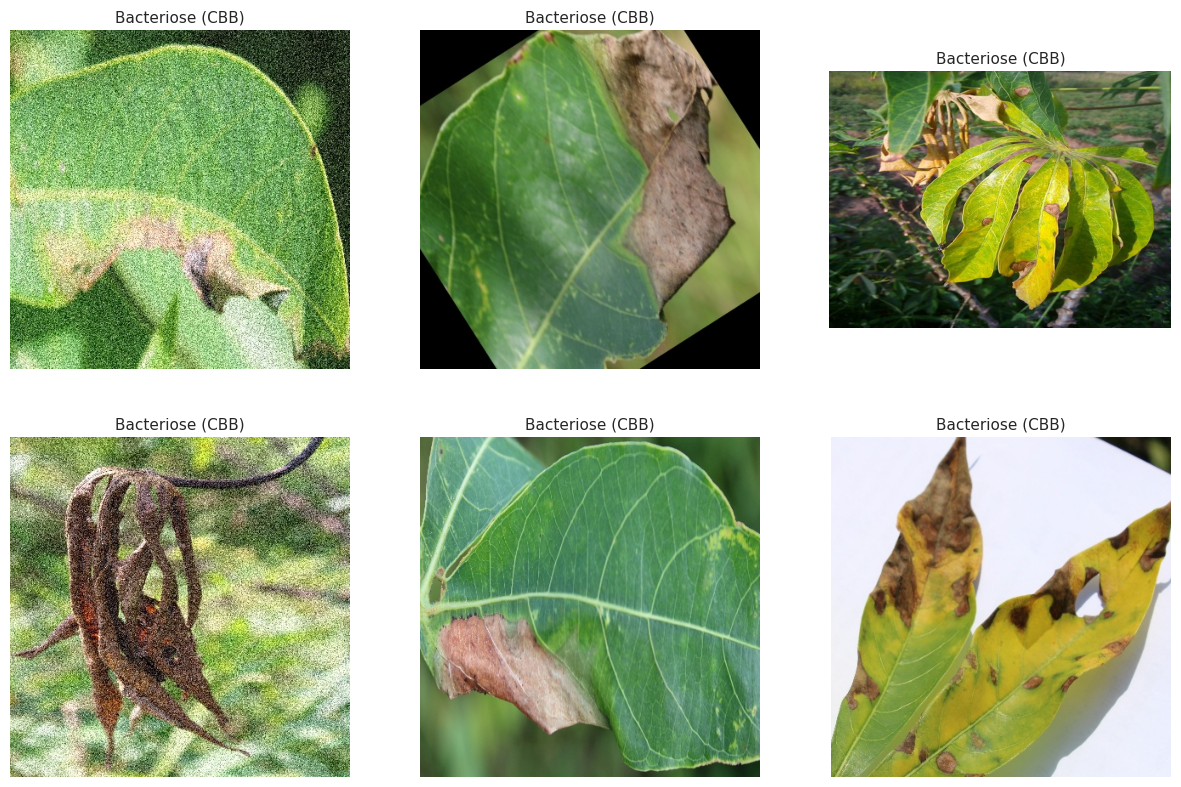

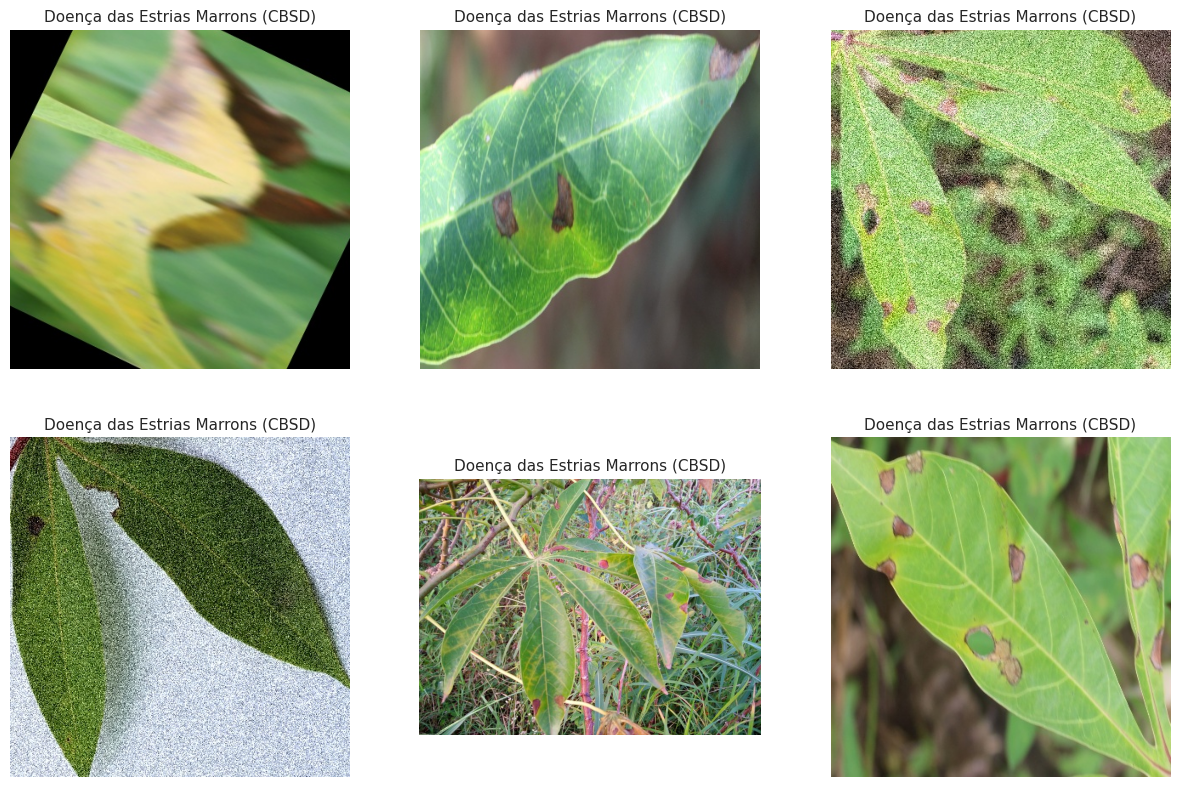

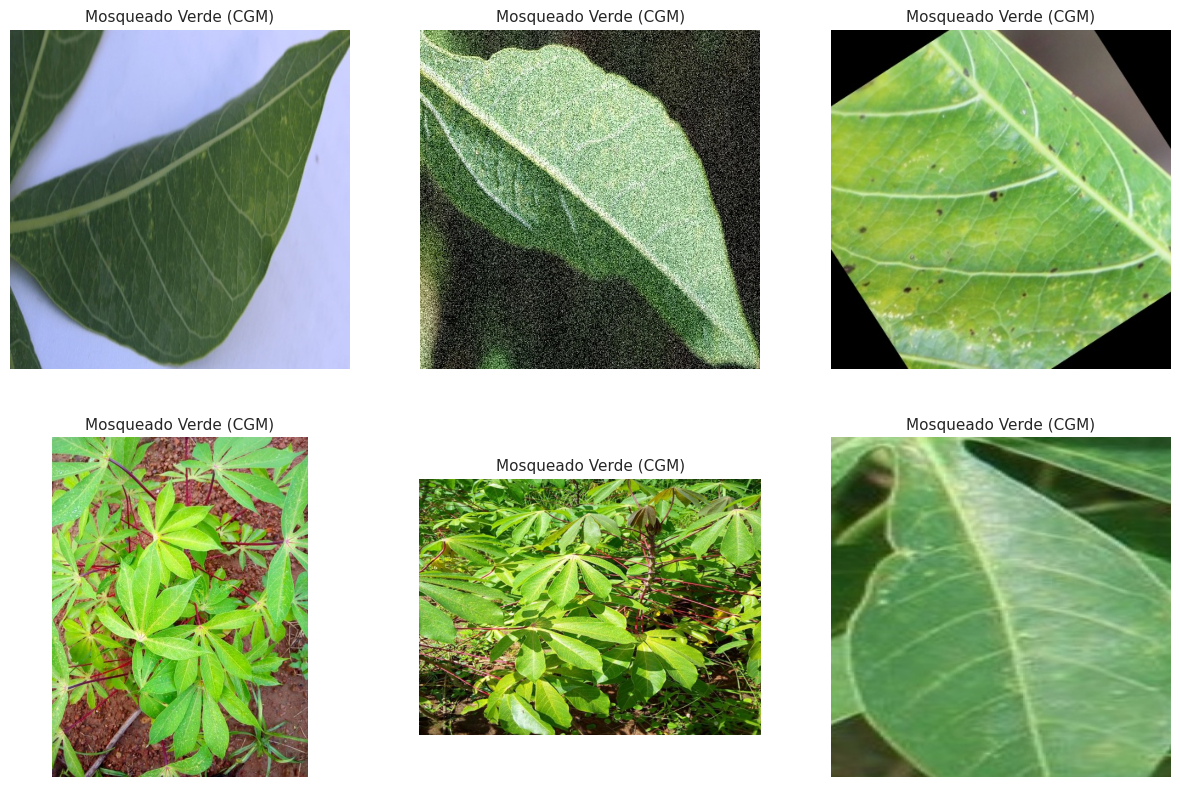

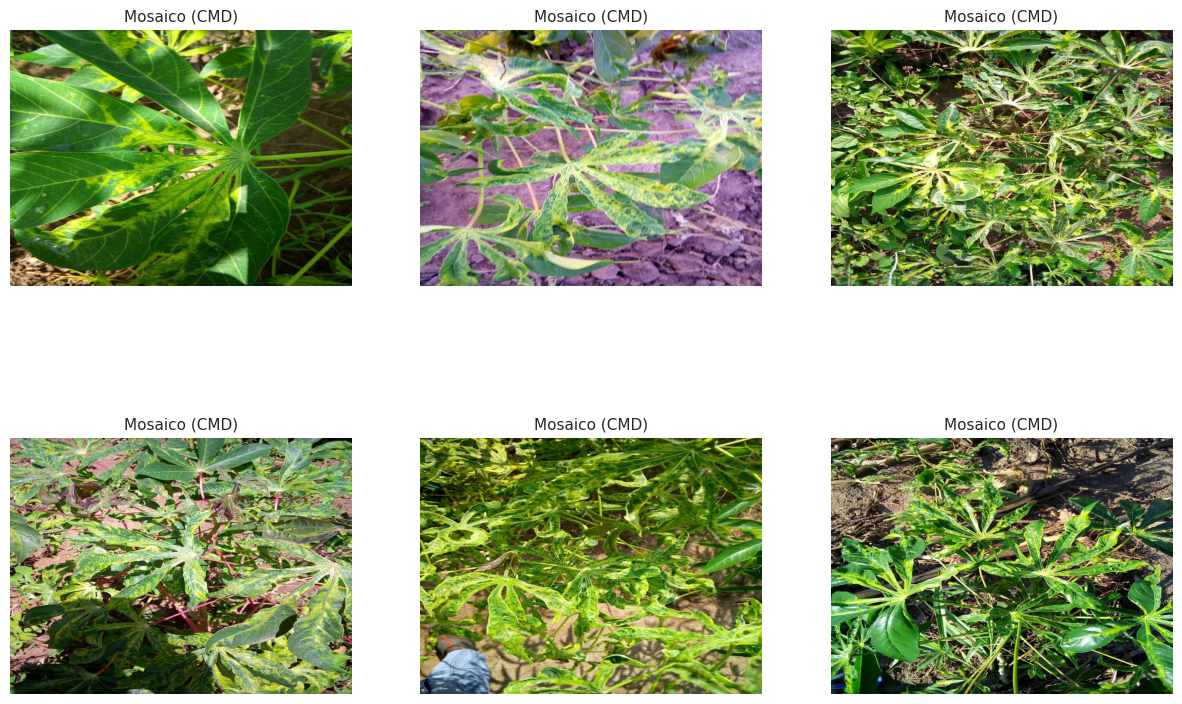

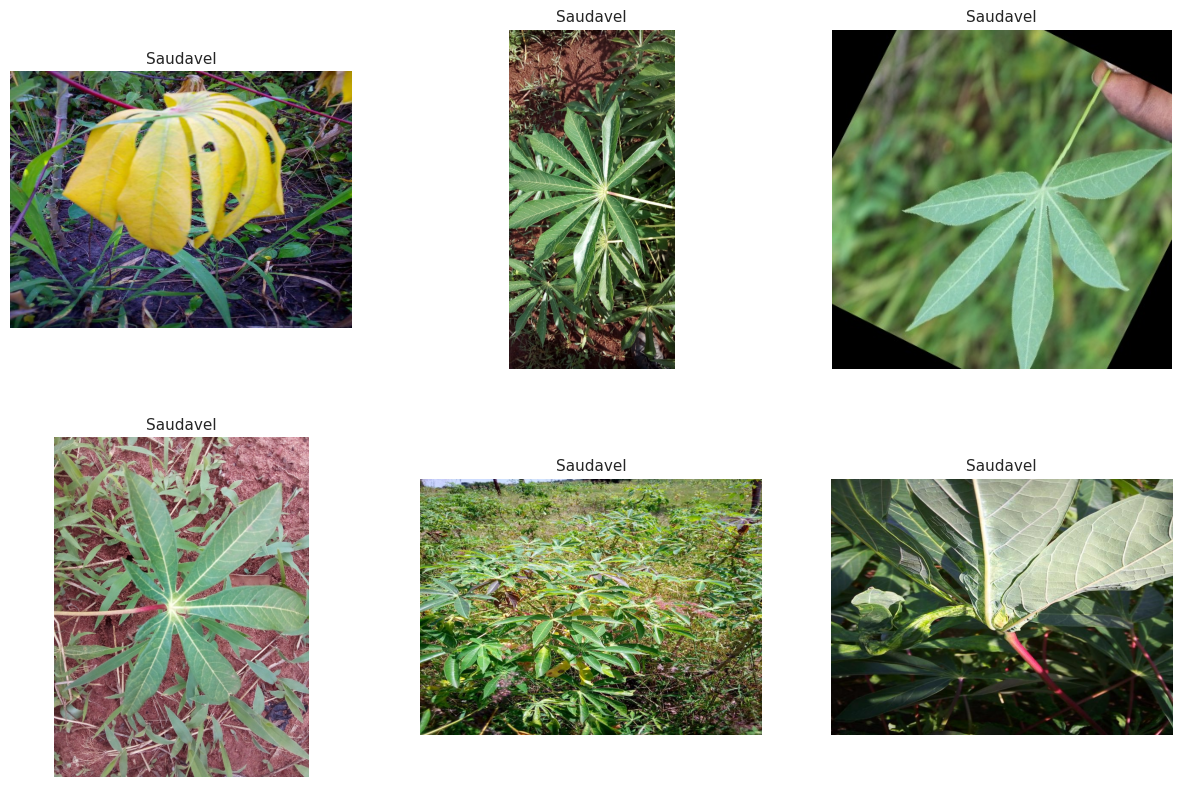

In [10]:
for i in range(5):
    plot_images(i, map_labels[i], 6)

<Axes: xlabel='count', ylabel='label_name'>

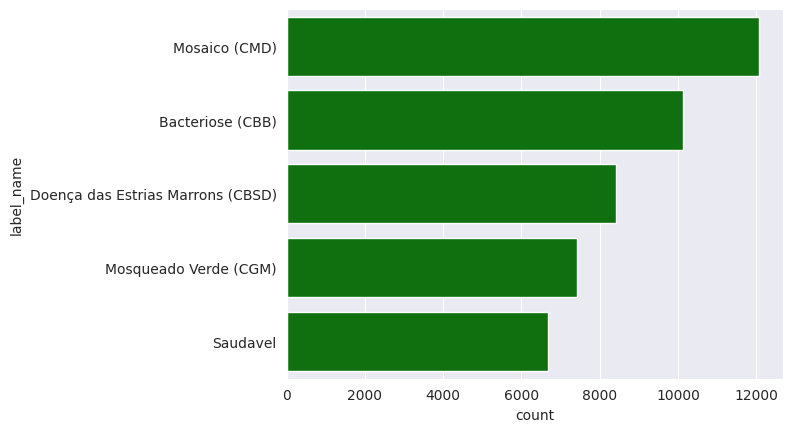

In [11]:
sns.countplot(y=train['label_name'], order = train['label_name'].value_counts().index, color = 'green')

Parâmetros

In [12]:
DIM = (224, 224) #mesma dimensão que nossa vitima costumava aprender
WIDTH, HEIGHT = DIM
NUM_CLASSES = 5
NUM_WORKERS = int(mp.cpu_count() * 0.75) # 75% dos nucleos da CPU, se for 8/16, usará 6/12
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16
SEED = 1
DEVICE = 'cuda'
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Augmentation

In [13]:
def get_transforms(value = 'val'):
    if value == 'train':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.Rotate(limit=(-90, 90)),
            albumentations.VerticalFlip(p=0.5),
            albumentations.Normalize(mean = MEAN, std = STD, max_pixel_value = 255.0, always_apply = True),
            ToTensorV2(p=1.0)
        ])
    elif value == 'val':
        return albumentations.Compose([
            albumentations.Resize(WIDTH, HEIGHT),
            albumentations.Normalize(mean = MEAN, std = STD, max_pixel_value = 255.0, always_apply = True),
            ToTensorV2(p=1.0)
        ])

In [14]:
class DatasetMandioca(Dataset):
    def __init__(self, image_ids, labels, dimension=None, augmentations=None, folder='train_images'):
        super().__init__()
        self.image_ids = image_ids
        self.labels = labels
        self.dim = dimension
        self.augmentations = augmentations
        self.folder = folder

    def __len__(self):
        return len(self.image_ids)

    # retorna a imagem e o label para o índice
    def __getitem__(self, idx):
        img = Image.open(os.path.join(BASE_DIR, self.folder, self.image_ids[idx]))

        if self.dim:
            img = img.resize(self.dim)

        # converte para numpy array
        img = np.array(img)

        if self.augmentations:
            augmented = self.augmentations(image=img)
            img = augmented['image']

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train['image_id'], train['label'], test_size=0.25)

In [16]:
from torch.utils.data import WeightedRandomSampler
def sampler_(labels):
    label_unique, counts = np.unique(labels, return_counts=True)
    print('Labels únicos', label_unique)
    weights = [sum(counts) / c for c in counts]
    sample_weights = [weights[w] for w in labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

In [17]:
train_sampler = sampler_(y_train)

Labels únicos [0 1 2 3 4]


In [18]:
train_dataset = DatasetMandioca(
    image_ids=x_train.values,
    labels=y_train.values,
    augmentations=get_transforms('train'),
    dimension=DIM
)

train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
    sampler=train_sampler
)

val_dataset = DatasetMandioca(
    image_ids=x_test.values,
    labels=y_test.values,
    augmentations=get_transforms('val'),
    dimension=DIM
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

loaders = {'train': train_loader, 'val': val_loader}

Transfer Learning \
Nossa "Vítima" de cola será a ResNext101_32x8d pré-treinada 

In [19]:
def Vitima():
    net = models.resnext101_32x8d(pretrained=True)

    for param in net.parameters():
        param.requires_grad = False

    num_ftrs = net.fc.in_features

    net.fc = nn.Sequential(
        nn.Linear(num_ftrs, 224),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(224, NUM_CLASSES),
        nn.LogSoftmax(dim=1)
    )

    net = net.cuda() if DEVICE else net
    return net

In [20]:
model = Vitima()

Learning Rate adaptativo, o código abaixo encontra o melhor LR em uma espécie de loop

In [21]:
import math
def lr_adaptativo(stepsize, min_lr=3e-4, max_lr=3e-3):

    scaler = lambda x: 1.
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1., momentum=0.9)
step_size = 4*len(train_loader)
autoLR = lr_adaptativo(step_size, min_lr=3e-4, max_lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [autoLR])

In [23]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [24]:
unfreeze = True #no Transfer Learning, podemos congelar as camadas iniciais e treinar apenas as camadas finais
for param in model.parameters():
    param.requires_grad = unfreeze

In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total de parâmetros')
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{trainable_params:,} parâmetros de treino')

87,202,437 total de parâmetros
87,202,437 parâmetros de treino


In [26]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5, scheduler=scheduler):
    # set starting time
    start_time = time.time()

    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []


    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1.0

    for epoch in range(num_epochs):
        print(f'Época {epoch}/{num_epochs-1}')
        print('-'*15)

        # each epoch have training and validation phase
        for phase in ['train', 'val']:
            # set mode for model
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            fin_out = []

            # iterate over data
            for inputs, labels in dataloaders[phase]:
                # move data to corresponding hardware
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # reset (or) zero the parameter gradients
                optimizer.zero_grad()

                # training (or) validation process
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # back propagation in the network
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # calculate loss and accuarcy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # print loss and acc for training & validation
            print('{} Perda: {:.4f} Acurácia: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_loss < best_loss: # salva o melhor modelo com base na perda
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
    end_time = time.time() - start_time

    print('Treino completado em {:.0f}m {:.0f}s'.format(end_time // 60, end_time % 60))
    print('Menor perda na validação: {:.4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, train_loss_history, val_acc_history, val_loss_history


In [27]:
modelo, acc_train, loss_train, acc_val, loss_val = train_model(model=model, dataloaders=loaders, criterion=criterion, optimizer=optimizer, num_epochs=6, scheduler=scheduler)

Época 0/5
---------------


MIOpen(HIP): Warning [FindSolutionImpl] Invalid config loaded from Perf Db: ConvBinWinogradRxSf3x2: 40. Performance may degrade.


train Perda: 0.6506 Acurácia: 0.7614
val Perda: 0.4090 Acurácia: 0.8539

Época 1/5
---------------
train Perda: 0.4249 Acurácia: 0.8507
val Perda: 0.4319 Acurácia: 0.8496

Época 2/5
---------------
train Perda: 0.3965 Acurácia: 0.8621
val Perda: 0.4779 Acurácia: 0.8261

Época 3/5
---------------
train Perda: 0.3775 Acurácia: 0.8667
val Perda: 0.4964 Acurácia: 0.8328

Época 4/5
---------------
train Perda: 0.3390 Acurácia: 0.8810
val Perda: 0.3553 Acurácia: 0.8761

Época 5/5
---------------
train Perda: 0.2823 Acurácia: 0.9026
val Perda: 0.3095 Acurácia: 0.8964

Treino completado em 140m 4s
Menor perda na validação: 0.3095


In [28]:
acc_train = [a.detach().cpu().numpy() for a in acc_train]

In [29]:
acc_val = [a.detach().cpu().numpy() for a in acc_val]

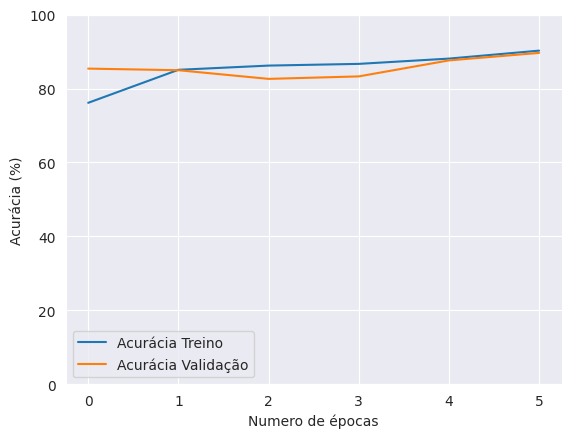

In [30]:
plt.plot(np.array(acc_train)*100)
plt.plot(np.array(acc_val)*100)
plt.legend(['Acurácia Treino', 'Acurácia Validação'])
plt.xlabel('Numero de épocas')
plt.ylabel('Acurácia (%)')
plt.ylim(0,100)
plt.show()

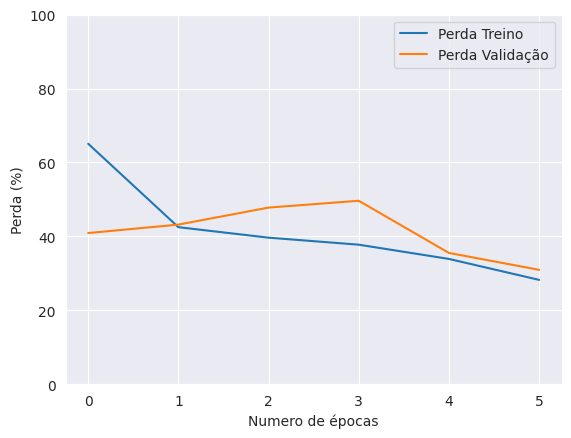

In [31]:
plt.plot(np.array(loss_train)*100)
plt.plot(np.array(loss_val)*100)
plt.legend(['Perda Treino', 'Perda Validação'])
plt.xlabel('Numero de épocas')
plt.ylabel('Perda (%)')
plt.ylim(0,100)
plt.show()

De acordo com testes em dados reais, bastou uma época, mais que isso overfita o modelo.

Agora vamos salvar o modelo

In [32]:
torch.save(modelo, BASE_DIR + 'MOACIR.h5')
torch.save(modelo.state_dict(), BASE_DIR + 'melhores_pesos')

Congelar modelo

In [33]:
unfreeze = False #mudar para true congela
for param in model.parameters():
    param.requires_grad = unfreeze

Testando o modelo

In [34]:
torch.cuda.empty_cache()

In [35]:
def predict(model, dataloader, device):

    model.eval()
    fin_out = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)

            fin_out.append(F.softmax(outputs, dim=1).detach().cpu().numpy())

    return np.concatenate(fin_out)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelo.to(device)
pred = predict(modelo, val_loader, device)
pred = pred.argmax(axis=1)

In [43]:
pred = predict(modelo, val_loader, device)
pred = pred.argmax(axis=1)

In [44]:
import sklearn.metrics

In [45]:
map_labels

{0: 'Bacteriose (CBB)',
 1: 'Doença das Estrias Marrons (CBSD)',
 2: 'Mosqueado Verde (CGM)',
 3: 'Mosaico (CMD)',
 4: 'Saudavel'}

<Axes: >

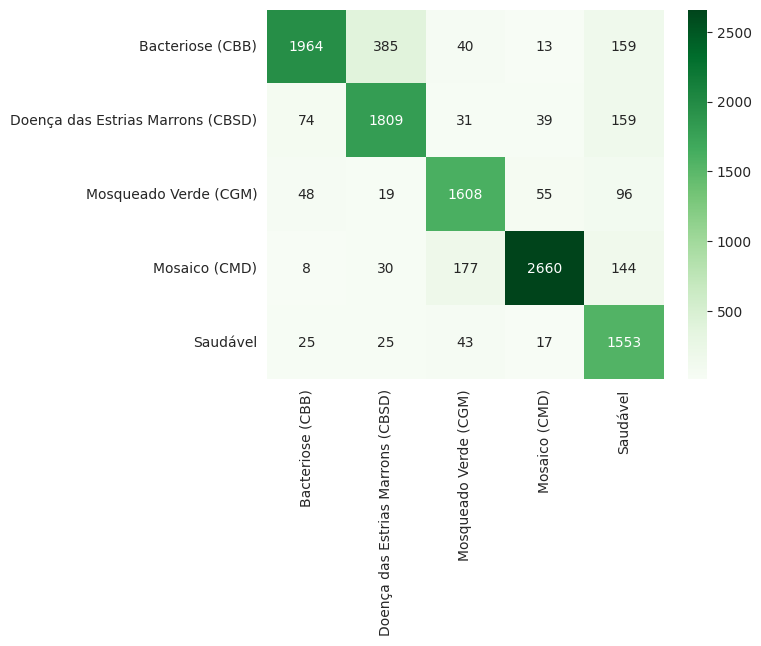

In [46]:
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, pred, labels=[0, 1, 2, 3, 4]), annot=True, fmt='d', cmap='Greens', xticklabels=['Bacteriose (CBB)', 'Doença das Estrias Marrons (CBSD)', 'Mosqueado Verde (CGM)', 'Mosaico (CMD)', 'Saudável'], yticklabels=['Bacteriose (CBB)', 'Doença das Estrias Marrons (CBSD)', 'Mosqueado Verde (CGM)', 'Mosaico (CMD)', 'Saudável'])

In [47]:
relatorio = sklearn.metrics.classification_report(y_test, pred, target_names=[map_labels[i] for i in range(5)])

In [48]:
print(relatorio)

                                   precision    recall  f1-score   support

                 Bacteriose (CBB)       0.93      0.77      0.84      2561
Doença das Estrias Marrons (CBSD)       0.80      0.86      0.83      2112
            Mosqueado Verde (CGM)       0.85      0.88      0.86      1826
                    Mosaico (CMD)       0.96      0.88      0.92      3019
                         Saudavel       0.74      0.93      0.82      1663

                         accuracy                           0.86     11181
                        macro avg       0.85      0.86      0.85     11181
                     weighted avg       0.87      0.86      0.86     11181



## Carregamento e uso do modelo para imagens reais será mostrado no notebook LOAD.ipynb

## Referências: 
https://www.kaggle.com/c/cassava-leaf-disease-classification/data \
https://www.youtube.com/watch?v=R7fKjr4gtSc 